In [1]:
import sys
sys.path.append(r"C:\Users\eg38emed\FCD\FCD vs TSC\keras_utils")

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical # get categorical labels

import tensorflow as tf
from keras.models import Sequential, Model
from keras import optimizers, applications
from keras import backend
from keras.layers import GlobalMaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, AveragePooling2D, Concatenate
from image.image_data_generator import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array
from image.directory_iterator import DirectoryIterator
from image.dataframe_iterator import DataFrameIterator
from keras.metrics import categorical_accuracy
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint, Callback, LambdaCallback, CSVLogger

In [6]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#visualize Augmentation from directory!
def looking_at_augmentation (data_generator, batchsize, path):
    im, label = next(data_generator)
    im = (im - np.min(im))/np.ptp(im) # to normalize all images --> matplotlib only takes pos. values between 0..1 / 0..255 
    imgs = list(im)
    labels = list(label)
    
    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Augmented Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, im  in enumerate(imgs[:batchsize]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(im)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    #fig.tight_layout()
    fig.savefig(base_path + '\\Augmented-Images.png', dpi=300)

#fast plot of training history
def plot_history(history, modelname, path):
    hist_df = pd.DataFrame(history.history)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
    axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=5, label='Validation MLogLoss')
    axs[1].plot(hist_df.loss, lw=5, label='Training MLogLoss')
    axs[1].set_ylabel('MLogLoss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    fig.savefig(path + '\History_{}.png' .format(modelname), dpi=300)
    hist_df.to_csv()
    plt.show();

from sklearn.metrics import roc_curve, roc_auc_score, auc#plotting the receiver operating characteristics --> evaluate performance cutting point vice
def plot_roc(label, predictions, modelname, path): #IDEA: set diffrent cutting point based on ROC for ensembling   
    roc_auc_score(label, predictions)
    print('The ROC-Score is: {}' .format(roc_auc_score))

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label, predictions)
    auc_keras = auc(fpr_keras, tpr_keras)
    #print(auc_keras)

    fig = plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve: {}' .format(auc_keras))
    plt.legend(loc='best')
    fig.savefig(path + '\ROC-Curve_{}.png' .format(modelname), dpi=300) #saving PLOT 
    plt.show()
    
from sklearn.metrics import confusion_matrix
import itertools
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
#plotting correctly classified images: https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
def plot_correct(vals, y_pred, y_label, modelname, path):
    correct = np.where(y_pred==y_label)[0]
    print ("Found %d correct labels" % len(correct))


    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=0.5)
    plt.suptitle('Correct Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, correct in enumerate(correct[:9]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(vals[correct])
        ax.set_title("Predicted {}, Class {}".format(y_pred[correct], y_label[correct]), fontsize=10)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    fig.savefig(path + '\Correct_Images_{}.png' .format(modelname), dpi=100) #saving PLOT 

#Plotting incorrectly classified
def plot_incorrect(vals, y_pred, y_label, modelname, path):
    incorrect = np.where(y_pred!=y_label)[0]
    print ("Found %d incorrect labels" % len(incorrect))


    fig, ax = plt.subplots(ncols=3, nrows=3)
    fig.subplots_adjust(hspace=1)
    plt.suptitle('Incorrect Images', fontsize=16)
    plt.figure(num=None, figsize=(50, 50), dpi=100, facecolor='w', edgecolor='k')

    for ax in ax.flatten():
        ax.axis('off')

    for i, incorrect in enumerate(incorrect[:9]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(vals[incorrect])
        ax.set_title("Predicted {}, Class {}".format(y_pred[incorrect], y_label[incorrect]), fontsize=10)
        fig.set_figheight(8)
        fig.set_figwidth(8)

    fig.savefig(path + '\Incorrect_Images_{}.png' .format(modelname), dpi=100) #saving PLOT 
    
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [7]:
#IMAGEAUGMENTATION WITHOUT SCALE TRANSLATE etc. 
import imgaug as ia
from imgaug import augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 20% of all images
        iaa.SomeOf((0, 4), [
                sometimes(iaa.Superpixels(p_replace=(0.1, 0.3), n_segments=(5, 10))), #superpixel-representation --> better basallamina representation 
                iaa.OneOf([
                    iaa.GaussianBlur((0, 0.2)), #small blur effects --> better representation
                    iaa.AverageBlur(k=(1, 3)), # k must be odd
                    iaa.MedianBlur(k=(1, 3)), # 
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), #cell wall represenation
                iaa.Emboss(alpha=(0, 0.8), strength=(0, 0.5)), #cell wall represenation
                #searching for edges or angles --> blobby mask --> better basallamina representation / nuclei
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.2, 0.4)), #detects edges --> cell wall,..
                    iaa.DirectedEdgeDetect(alpha=(0.2, 0.4), direction=(0.0, 1.0)), #direction will make edges from random directions 
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.2), # add gaussian noise to images
             iaa.OneOf([
                    iaa.Dropout((0.05, 0.3), per_channel=0.2), #rnd remove 5% in small pixels
                    iaa.CoarseDropout((0.05, 0.3), size_percent=(0.01, 0.02), per_channel=0.2),# rnd remove 3% in big pixels
                ]),
                iaa.Invert(0.01, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.3), # change brightness of images (by -10 to 10 of original value)
                #iaa.AddToHueAndSaturation((-0.1, 0.1)), # change hue and saturation
                #
                #either change the brightness of the whole image (sometimes per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.9, 1.2), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-1, 0),
                        first=iaa.Multiply((0.9, 1.1), per_channel=True),
                        second=iaa.ContrastNormalization((0.9, 1.1))
                    )
                ]),
                sometimes(iaa.ElasticTransformation(alpha=(0, 0.5), sigma=0.1)), #still not sure: move pixels locally around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.03))), #still not sure:move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                     random_order=True
        )
    ],
    random_order=True
)

In [15]:
IMAGE_SIZE = 100
IMAGE_CHANNELS = 3

model_name = 'VGG_RCZ_1'

base_path = (r'C:\Users\eg38emed\FCD\kfold_RCZ/base_dir_fold_1/{}'.format(model_name))
if not os.path.exists(base_path):
    os.makedirs(base_path)

train_path = (r'C:\Users\eg38emed\FCD\kfold_RCZ/base_dir_fold_1/train_dir')
val_path = (r'C:\Users\eg38emed\FCD\kfold_RCZ/base_dir_fold_1/val_dir')

In [6]:
train_batch_size_1 = 128
val_batch_size = 64

datagen_train = ImageDataGenerator(preprocessing_function=seq.augment_image,
                                   rotate_random_zoom_crop=True,
                                   rescale=1./255)

datagen_val = ImageDataGenerator(rescale=1./255,
                                rotate_random_zoom_crop=True)



train_gen_1 = datagen_train.flow_from_directory(train_path,
                                        #target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        crop_size = (100, 100),
                                        batch_size=train_batch_size_1,
                                        class_mode='categorical')

val_gen = datagen_val.flow_from_directory(val_path,
                                        #target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        crop_size = (100, 100),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

num_train_samples = train_gen_1.samples
num_val_samples = val_gen.samples
print(num_train_samples)
print(num_val_samples)

Found 2300 images belonging to 2 classes.
Found 248 images belonging to 2 classes.
2300
248


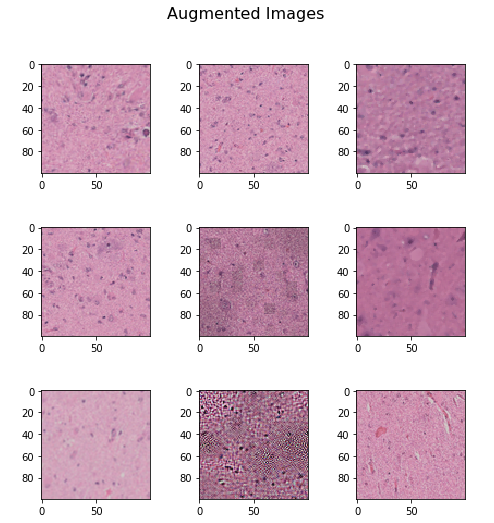

<Figure size 5000x5000 with 0 Axes>

In [7]:
looking_at_augmentation(train_gen_1, batchsize=9, path=base_path)

In [13]:
#VGG-16 with BatchNorm + 2. Denselayer
def get_model_classif_VGG_base_nottrainable():
    base_model_VGG = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    print('Model loaded.')
    
    for layer in base_model_VGG.layers:
        layer.trainable = False
        print("trainable:", layer.name)
    
    x = base_model_VGG.output
    out = GlobalMaxPooling2D(name='1')(x)
    x = BatchNormalization(name='2')(out)
    x = Dropout(0.5, name='3')(x)
    x = Dense(512, activation='relu',name='4') (x)
    x = BatchNormalization(name='5')(x)
    x = Dropout(0.2, name='6')(x)
    x = Dense(256, activation='relu',name='7') (x)
    x = BatchNormalization(name='8')(x)
    
    predictions = (Dense(2, activation='softmax'))(x)
    model_VGG = Model(inputs=base_model_VGG.input, outputs=predictions)

    adam = optimizers.Adam()
    model_VGG.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=[categorical_accuracy, auc_roc])

    model_VGG.summary()
    return model_VGG

def get_model_classif_VGG_base_trainable():
    base_model_VGG = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    print('Model loaded.')
    
    for layer in base_model_VGG.layers:
        layer.trainable = True
        print("trainable:", layer.name)
    
    x = base_model_VGG.output
    out = GlobalMaxPooling2D(name='1')(x)
    x = BatchNormalization(name='2')(out)
    x = Dropout(0.5, name='3')(x)
    x = Dense(512, activation='relu',name='4') (x)
    x = BatchNormalization(name='5')(x)
    x = Dropout(0.5, name='6')(x)
    x = Dense(256, activation='relu',name='7') (x)
    x = BatchNormalization(name='8')(x)
    
    predictions = (Dense(2, activation='softmax'))(x)
    model_VGG = Model(inputs=base_model_VGG.input, outputs=predictions)

    adam = optimizers.Adam()
    model_VGG.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=[categorical_accuracy, auc_roc])

    model_VGG.summary()
    return model_VGG

# Training Toplayers

In [9]:
model_VGG = get_model_classif_VGG_base_nottrainable()
#model_VGG.load_weights('C:\Users\eg38emed\FCD\Models\VGG_dataset2_clr\VGG_dataset2_clr.h5')

Model loaded.
trainable: input_1
trainable: block1_conv1
trainable: block1_conv2
trainable: block1_pool
trainable: block2_conv1
trainable: block2_conv2
trainable: block2_pool
trainable: block3_conv1
trainable: block3_conv2
trainable: block3_conv3
trainable: block3_pool
trainable: block4_conv1
trainable: block4_conv2
trainable: block4_conv3
trainable: block4_pool
trainable: block5_conv1
trainable: block5_conv2
trainable: block5_conv3
trainable: block5_pool
Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block

In [ ]:
from keras_lr_finder import LRFinder
lr_gen = datagen_train.flow_from_directory(train_path,
                                        #target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        crop_size = (100,100),
                                        batch_size=5000,
                                        class_mode='categorical')

x_lr_train,y_lr_train= lr_gen.next()
print(x_lr_train.shape)
lr_finder = LRFinder(model_VGG)

In [ ]:
lr_finder.find(x_lr_train, y_lr_train, 0.000001, 0.1, batch_size=128, epochs=4)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

In [10]:
import clr_callback
def get_callbacks_clr(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    clr = clr_callback.CyclicLR(base_lr=0.0001, max_lr=0.01,
                        step_size=num_train_samples/train_batch_size_1/2)
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_toplayer.csv".format(model_name), append=True)
    return [clr, earlystopping, ReduceLR, checkpoint, csv_logger]

def get_callbacks(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_toplayer.csv".format(model_name), append=True)
    return [earlystopping, ReduceLR, checkpoint, csv_logger]

name_weights = (base_path + "\\{}_toplayer.h5".format(model_name))
callbacks_list = get_callbacks_clr(name_weights = name_weights)

In [11]:
#model_VGG.load_weights(base_path + "\\{}.h5".format(model_name))
history = model_VGG.fit_generator(train_gen_1, 
                    steps_per_epoch=train_gen_1.samples // train_batch_size_1*10, 
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // val_batch_size*10,
                    epochs=20, verbose=1,
                    callbacks=callbacks_list)

plot_history(history, modelname = model_name, path=base_path)

Epoch 1/20
170/170 [==============================] - 1918s 11s/step - loss: 0.6419 - categorical_accuracy: 0.6330 - auc_roc: 0.6227 - val_loss: 0.6600 - val_categorical_accuracy: 0.6035 - val_auc_roc: 0.6828

Epoch 00001: val_categorical_accuracy improved from -inf to 0.60354, saving model to C:\Users\eg38emed\FCD\Models\VGG_RCZ\VGG_RCZ.h5
Epoch 2/20
170/170 [==============================] - 1814s 11s/step - loss: 0.5863 - categorical_accuracy: 0.6769 - auc_roc: 0.6985 - val_loss: 0.5859 - val_categorical_accuracy: 0.7010 - val_auc_roc: 0.7156

Epoch 00002: val_categorical_accuracy improved from 0.60354 to 0.70097, saving model to C:\Users\eg38emed\FCD\Models\VGG_RCZ\VGG_RCZ.h5
Epoch 3/20
170/170 [==============================] - 1897s 11s/step - loss: 0.5735 - categorical_accuracy: 0.6903 - auc_roc: 0.7254 - val_loss: 0.5790 - val_categorical_accuracy: 0.7049 - val_auc_roc: 0.7330

Epoch 00003: val_categorical_accuracy improved from 0.70097 to 0.70494, saving model to C:\Users\eg38

KeyboardInterrupt: 

# Training baselayers

In [9]:
#FINETUNE ALL VGG
model_VGG = get_model_classif_VGG_base_trainable()
#model_VGG.load_weights(base_path + "\\{}_100_ALL.h5".format(model_name))

Model loaded.
trainable: input_1
trainable: block1_conv1
trainable: block1_conv2
trainable: block1_pool
trainable: block2_conv1
trainable: block2_conv2
trainable: block2_pool
trainable: block3_conv1
trainable: block3_conv2
trainable: block3_conv3
trainable: block3_pool
trainable: block4_conv1
trainable: block4_conv2
trainable: block4_conv3
trainable: block4_pool
trainable: block5_conv1
trainable: block5_conv2
trainable: block5_conv3
trainable: block5_pool
Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block

In [13]:
from keras_lr_finder import LRFinder
lr_gen = datagen_train.flow_from_directory(train_path,
                                        #target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        crop_size = (100,100),
                                        batch_size=5000,
                                        class_mode='categorical')

x_lr_train,y_lr_train= lr_gen.next()
print(x_lr_train.shape)
lr_finder = LRFinder(model_VGG)

Found 2300 images belonging to 2 classes.
(2300, 100, 100, 3)


no list
Epoch 1/4
2300/2300 [==============================] - 7s 3ms/step - loss: 0.7793 - categorical_accuracy: 0.5117 - auc_roc: 0.5113
Epoch 2/4
2300/2300 [==============================] - 4s 2ms/step - loss: 0.7159 - categorical_accuracy: 0.5643 - auc_roc: 0.5346
Epoch 3/4
2300/2300 [==============================] - 4s 2ms/step - loss: 0.7597 - categorical_accuracy: 0.4987 - auc_roc: 0.5459
Epoch 4/4
 256/2300 [==>...........................] - ETA: 3s - loss: 2.5050 - categorical_accuracy: 0.5195 - auc_roc: 0.5398

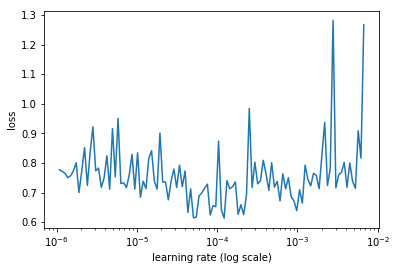

In [14]:
lr_finder.find(x_lr_train, y_lr_train, 0.000001, 0.1, batch_size=64, epochs=4)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)

In [ ]:
#clr.reset()

In [10]:
import clr_callback
def get_callbacks_clr(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.25, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    clr = clr_callback.CyclicLR(base_lr=0.000005, max_lr=0.00005,
                        step_size=num_train_samples/train_batch_size_1/2)
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_ALL.csv".format(model_name), append=True)
    return [clr, earlystopping, ReduceLR, checkpoint, csv_logger]

def get_callbacks(name_weights):
    ReduceLR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.25, patience=5, verbose=1, mode='auto', cooldown=5, min_lr=0.00005)
    earlystopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(name_weights, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    csv_logger = CSVLogger(filename = base_path + "\\model_history_{}_ALL.csv".format(model_name), append=True)
    return [earlystopping, ReduceLR, checkpoint, csv_logger]

name_weights = (base_path + "\\{}_ALL.h5".format(model_name))
callbacks_list = get_callbacks_clr(name_weights = name_weights)

In [11]:
model_VGG.load_weights(base_path + "\\{}_toplayer.h5".format(model_name))
history = model_VGG.fit_generator(train_gen_1, 
                    steps_per_epoch=train_gen_1.samples // train_batch_size_1*10, 
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // val_batch_size*10,
                    epochs=40, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/40
170/170 [==============================] - 1910s 11s/step - loss: 0.6080 - categorical_accuracy: 0.5789 - auc_roc: 0.6556 - val_loss: 0.5659 - val_categorical_accuracy: 0.6422 - val_auc_roc: 0.6883

Epoch 00001: val_categorical_accuracy improved from -inf to 0.64217, saving model to C:\Users\eg38emed\FCD\Models\VGG_RCZ\VGG_RCZ_100_DO0.5_ALL.h5
Epoch 2/40
170/170 [==============================] - 1802s 11s/step - loss: 0.4848 - categorical_accuracy: 0.7539 - auc_roc: 0.7420 - val_loss: 0.4123 - val_categorical_accuracy: 0.7775 - val_auc_roc: 0.7800

Epoch 00002: val_categorical_accuracy improved from 0.64217 to 0.77748, saving model to C:\Users\eg38emed\FCD\Models\VGG_RCZ\VGG_RCZ_100_DO0.5_ALL.h5
Epoch 3/40
170/170 [==============================] - 1882s 11s/step - loss: 0.4240 - categorical_accuracy: 0.7964 - auc_roc: 0.8053 - val_loss: 0.3820 - val_categorical_accuracy: 0.8455 - val_auc_roc: 0.8230

Epoch 00003: val_categorical_accuracy improved from 0.77748 to 0.84549, s

170/170 [==============================] - 1855s 11s/step - loss: 0.2045 - categorical_accuracy: 0.9087 - auc_roc: 0.9494 - val_loss: 0.3336 - val_categorical_accuracy: 0.8568 - val_auc_roc: 0.9499

Epoch 00027: val_categorical_accuracy did not improve from 0.95905
Epoch 28/40
170/170 [==============================] - 1821s 11s/step - loss: 0.1895 - categorical_accuracy: 0.9161 - auc_roc: 0.9504 - val_loss: 0.1032 - val_categorical_accuracy: 0.9650 - val_auc_roc: 0.9510

Epoch 00028: val_categorical_accuracy improved from 0.95905 to 0.96498, saving model to C:\Users\eg38emed\FCD\Models\VGG_RCZ\VGG_RCZ_100_DO0.5_ALL.h5
Epoch 29/40
170/170 [==============================] - 1825s 11s/step - loss: 0.1820 - categorical_accuracy: 0.9185 - auc_roc: 0.9517 - val_loss: 0.2302 - val_categorical_accuracy: 0.8965 - val_auc_roc: 0.9523

Epoch 00029: val_categorical_accuracy did not improve from 0.96498
Epoch 30/40
170/170 [==============================] - 1917s 11s/step - loss: 0.1873 - categori

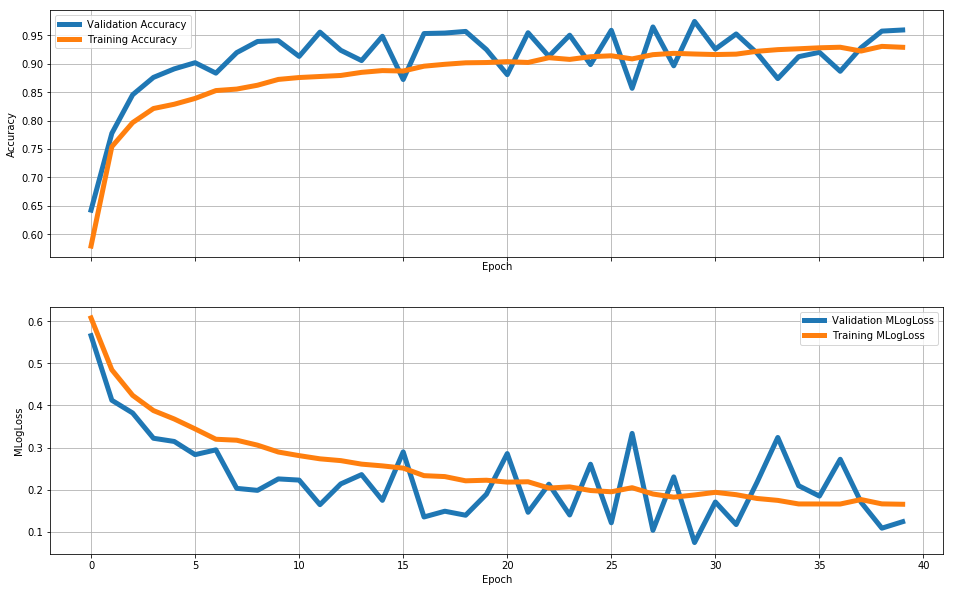

In [12]:
plot_history(history, modelname = model_name, path=base_path)

## Model Evaluation

In [9]:
# Setup the data_frame: Path, ID, Label, Image
tiles = (r"C:\Users\eg38emed\FCD\Tiles_RCZ")
test_path = tiles + '\\Validation'
print(test_path)

fcd = test_path +  '\\a_fcd'
tsc = test_path + '\\b_tsc'
print('FCD Path:' fcd)
#fcd folder
df = pd.DataFrame({'path': glob(os.path.join(fcd,'*.png'))})
df['id'] = df.path.map(lambda x: x.split('\\')[6].split('.')[0]) 
df['label'] = 0

#tsc folder
df_pos = pd.DataFrame({'path': glob(os.path.join(tsc,'*.png'))})
df_pos['id'] = df_pos.path.map(lambda x: x.split('\\')[6].split('.')[0]) 
df_pos['label'] = 1

#both
df_train = pd.concat([df, df_pos])

#add images
df_train['image'] = df_train['path'].map(imread)

print(len(df_train))
print(df_train.head())

#extracting images out of df
imgs = []
for img in df_train['image']:
    imgs.append(img)
        
X = np.asarray(imgs)
y = to_categorical(df_train['label'])

print(X.shape)
print(y.shape)

C:\Users\eg38emed\FCD\Tiles_RCZ\Validation
C:\Users\eg38emed\FCD\Tiles_RCZ\Validation\a_fcd
248
                                                path     id  label  \
0  C:\Users\eg38emed\FCD\Tiles_RCZ\Validation\a_f...  a_fcd      0   
1  C:\Users\eg38emed\FCD\Tiles_RCZ\Validation\a_f...  a_fcd      0   
2  C:\Users\eg38emed\FCD\Tiles_RCZ\Validation\a_f...  a_fcd      0   
3  C:\Users\eg38emed\FCD\Tiles_RCZ\Validation\a_f...  a_fcd      0   
4  C:\Users\eg38emed\FCD\Tiles_RCZ\Validation\a_f...  a_fcd      0   

                                               image  
0  [[[249, 190, 210], [248, 189, 211], [253, 191,...  
1  [[[241, 164, 200], [237, 159, 198], [232, 154,...  
2  [[[230, 199, 217], [226, 198, 213], [223, 195,...  
3  [[[255, 195, 223], [246, 183, 212], [240, 175,...  
4  [[[253, 224, 228], [255, 234, 238], [255, 224,...  
(248, 2041, 2041, 3)
(248, 2)


In [20]:
batch_size= 1
datagen_test = ImageDataGenerator(rescale=1./255,
                                rotate_random_zoom_crop=True)

test_generator = datagen_test.flow_from_directory(test_path, 
                                                  batch_size = batch_size, 
                                                  shuffle=False,#FALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSEFALSE
                                                  #target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                  crop_size = (100,100),
                                                  class_mode='categorical')

Found 248 images belonging to 2 classes.


In [21]:
#evaluate model on validation-data + test_datagen --> weights of best training epoch will be used
model_VGG = get_model_classif_VGG_base_trainable()
#model_VGG.load_weights(base_path + "\\VGG_kfold_4_ALL.h5")
model_VGG.load_weights(base_path + "\\VGG_RCZ_100_DO0.5_ALL.h5")
val_loss, val_acc, auc_roc = \
model_VGG.evaluate_generator(test_generator, 
                             steps=len(test_generator),
                             verbose=1)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

Model loaded.
trainable: input_5
trainable: block1_conv1
trainable: block1_conv2
trainable: block1_pool
trainable: block2_conv1
trainable: block2_conv2
trainable: block2_pool
trainable: block3_conv1
trainable: block3_conv2
trainable: block3_conv3
trainable: block3_pool
trainable: block4_conv1
trainable: block4_conv2
trainable: block4_conv3
trainable: block4_pool
trainable: block5_conv1
trainable: block5_conv2
trainable: block5_conv3
trainable: block5_pool
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool 

In [22]:
test_generator.reset()

In [23]:
predictions = model_VGG.predict_generator(test_generator, 
                                          steps=len(test_generator), 
                                          workers=6, 
                                          use_multiprocessing=False, 
                                          verbose=1)

248/248 [==============================] - 5s 18ms/step


In [24]:
# Get the true labels
y_label = np.argmax(y, axis=1)
print(y_label)
df_preds = pd.DataFrame(predictions, columns=['FCD', 'TSC'])
print(df_preds.head())
# Get the predicted labels as probabilities
y_pred = df_preds['TSC']

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
        FCD       TSC
0  0.999996  0.000004
1  0.897901  0.102099
2  0.999995  0.000005
3  0.998609  0.001391
4  0.999748  0.000252


The ROC-Score is: <function roc_auc_score at 0x00000187628E9620>


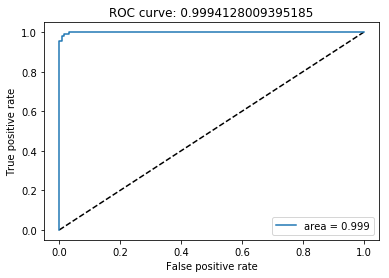

In [25]:
#maybe change pos/neg cutoff:
plot_roc(y_label, y_pred, modelname=model_name, path = base_path)

Confusion matrix, without normalization
[[129   2]
 [  1 116]]


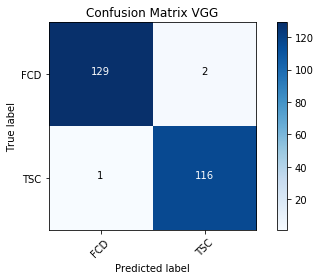

In [26]:
cm = confusion_matrix(y_label, y_pred.round())
cm_plot_labels = ['FCD', 'TSC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix VGG')

In [27]:
#rounding predictions + make them int --> compare to label / heatmap
y_pred = y_pred.round()
y_pred_int = []
for i in y_pred:
    if i == 1.0:
        y_pred_int.append(1)
    else:
        y_pred_int.append(0)

y_pred_int = np.asarray(y_pred_int)
print((y_pred_int.shape))

(248,)


Found 245 correct labels
Found 3 incorrect labels


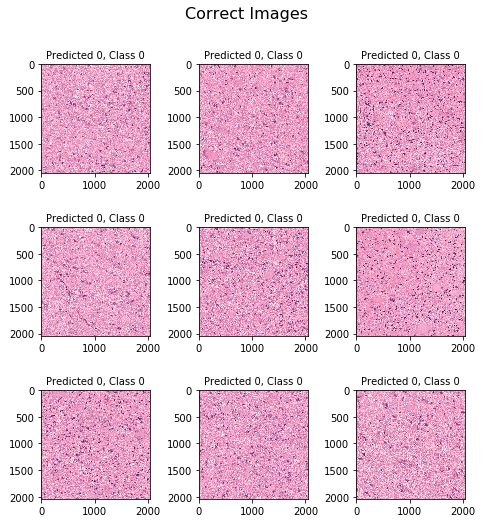

<Figure size 5000x5000 with 0 Axes>

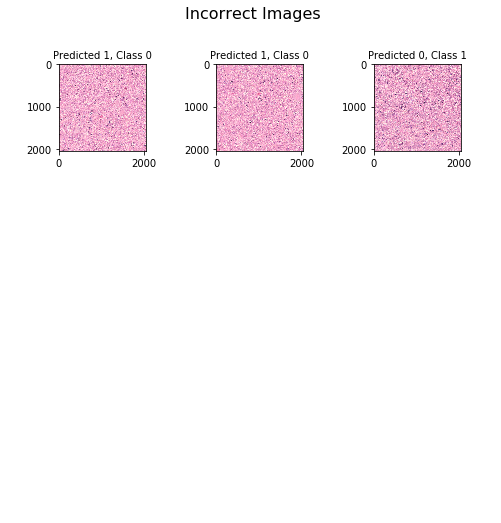

<Figure size 5000x5000 with 0 Axes>

In [31]:
plot_correct(X, y_pred_int, y_label, modelname=model_name, path=base_path)
plot_incorrect(X, y_pred_int, y_label, modelname=model_name, path=base_path)

In [ ]:
filenames = test_generator.filenames
incorrect = np.where(y_pred!=y_label)[0]
for i, incorrect in enumerate(incorrect):
    print(incorrect)
    print(filenames[incorrect])

In [ ]:
from  keras.preprocessing  import image

def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=10)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plots_idx(idx, titles=None):
    plots([image.load_img(test_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 10

In [ ]:
#3a. The images we most confident were FCD, and are actually FCD
correct_fcd = np.where((y_label==0) & (y_label==y_pred_int))[0]
print("Found %d confident correct FCD labels" % len(correct_fcd))
most_correct = np.argsort(y_predictions[correct_fcd])[:n_view]

plots_idx(correct_fcd[most_correct], y_predictions[correct_fcd][most_correct])

In [ ]:
#3b. The images we most confident were TSC, and are actually TSC
correct_tsc = np.where((y_label==1) & (y_label==y_pred_int))[0]
print("Found %d confident correct TSC labels" % len(correct_tsc))
most_correct_tsc = np.argsort(y_predictions[correct_tsc])[::-1][:20]
plots_idx(correct_tsc[most_correct_tumor], y_predictions[correct_tsc][most_correct_tsc])

In [ ]:
#4a. The images we were most confident were FCD, but are actually TSC
incorrect_fcd = np.where((y_label==1) & (y_pred_int!=y_label))[0]
print("Found %d incorrect TSC" % len(incorrect_fcd))
if len(incorrect_fcd):
    most_incorrect_fcd = np.argsort(y_predictions[incorrect_fcd])[:n_view]
    plots_idx(incorrect_fcd[most_incorrect_fcd], y_predictions[incorrect_fcd][most_incorrect_fcd])

In [ ]:
#4b. The images we were most confident were TSC, but are actually FCD
incorrect_tsc = np.where((y_label==0) & (y_pred_int!=y_label))[0]
print("Found %d incorrect FCD" % len(incorrect_tsc))
if len(incorrect_tsc):
    most_incorrect_tsc = np.argsort(y_predictions[incorrect_tsc])[::-1][:n_view]
    plots_idx(incorrect_tsc[most_incorrect_tsc], y_predictions[incorrect_tsc][most_incorrect_tsc])

In [ ]:
#5. The most uncertain labels (probability closest to 0.5).
most_uncertain = np.argsort(np.abs(y_predictions-0.5))
plots_idx(most_uncertain[:n_view], y_predictions[most_uncertain])